In [135]:
import datetime
from typing import Callable
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader.data as web
# Window length for moving average
length = 14

# Dates
start, end = '2010-01-01', '2020-01-27'

# Get data
data = web.DataReader('AAPL', 'yahoo', start, end)
# Get just the adjusted close
close = data['Adj Close']



# Define function to calculate the RSI
def rsi(data: pd.Series, win = 14 , ma = "EWMA") -> pd.Series:
    """
    Calculate rsi for a column in a pandas dataframe. 
    SMA calculates the average of price data, while EMA gives more weight to current data.
  
    Parameters:
    over (pandas.Series): dataframe that contains the column with numeric values to be calculated 
    w (int): Window of the rsi calculation
  
    Returns:
    float: rsi value is between 0 to 100
    """
    if  ma == "EWMA":
        fn_roll = lambda s: s.ewm(com=(win-1), adjust=True, min_periods = win).mean()
    elif ma == "EMA":
        fn_roll = lambda s: s.ewm(span = win,min_periods = win).mean()
    elif ma == "SMA":
        fn_roll = lambda s: s.rolling(win).mean()
    elif ma == "RMA":
        fn_roll = lambda s: s.ewm(alpha=1 / win).mean()
    else:
        raise ValueError(f"MA type: {ma} is not a valid method. Try EMA, SMA, RMA or EWMA")
    
    # Calculate diferences over every record from the previous one
    delta = data.diff()

    # Copy series. For ups and downs clip it value to 0 if negatives or positive respectively
    up, down = delta.copy(), delta.copy()
    
    up[up < 0] = 0
    down[down > 0] = 0
    down *= -1
    
    win_up = fn_roll(up) 
    win_down =  fn_roll(down)
  
    rs = win_up / win_down
    rsi = 100.0 - (100.0 / (1.0 + rs))
    
    # if win_down == 0 --> RS --> inf and rsi = 100
    # if win_up == 0 --> RS --> 0 and rsi = 0
    rsi[:] = np.select([win_down == 0, win_up == 0, True], [100.0, 0.0, rsi])
    rsi.name = 'rsi'

    # Assert that rsi (from win value in data (taking into account the first nan from diff) is
    # between 0 and 100. 
    check_rsi = rsi[length:]
    assert ((0 <= check_rsi) & (check_rsi <= 100)).all()
    
    return rsi

# # Calculate RSI using MA of choice
# # Reminder: Provide ≥ `1 + length` extra data points!
# rsi_ema = calc_rsi(close, "EMA")
# rsi_sma = calc_rsi(close )
# rsi_rma = calc_rsi(close, "RMA")  # Approximates TradingView.

# # Compare graphically
# plt.figure(figsize=(8, 6))
# rsi_ema.plot(), rsi_sma.plot(), rsi_rma.plot()
# plt.legend(['RSI via EMA/EWMA', 'RSI via SMA', 'RSI via RMA/SMMA/MMA (TradingView)'])
# plt.show()

In [33]:
%%timeit
delta = close.diff()
down = -1*delta.clip(upper=0)
up = delta.clip(lower=0)


848 µs ± 7.93 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [34]:
%%timeit
delta = close.diff()
up, down = delta.copy(), delta.copy()
up[up < 0] = 0
down[down > 0] = 0
down *= -1

559 µs ± 2.54 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [37]:
rsi_p = rsi(data = close, win = 14, ma = "EWMA")


Date
2010-01-04          NaN
2010-01-05          NaN
2010-01-06          NaN
2010-01-07          NaN
2010-01-08          NaN
                ...    
2020-01-21    74.745066
2020-01-22    75.451516
2020-01-23    76.413515
2020-01-24    74.522450
2020-01-27    58.625618
Name: rsi, Length: 2533, dtype: float64

In [168]:
df_rsi=pd.DataFrame(rsi_p)

In [190]:
import pandas
class stock_graphs():
    __data = {}
    __layout = {}
    __config = {
        'stock':
        {
            'b_view': False,
            'type': False,
            'stock_name':"",
            'currency_name':"",
            'simple_col': "Close",
            'simple_hover':"y",
            'color': "#42C4F7",
            'yaxis': "y1"
        },
        'rsi':
        {
            'b_view': False,
            'pos':'below',
            'type': False,
            'domain':"",
            'name': "Relative Strength Index",
            'window':14,
            'yaxis': "y2",
            'simple_col': "rsi",
            'simple_hover':"y",
            'color':"#a85c32"
        },
        'ma':
        {
            
            'b_view': False,
            'pos':'below',
            'type': False,
            'name': "Moving Average",
            'window': 14

        },
        "general":
        {
            'n_graphs':0,
            'indicators':["rsi","ma"],
            'domain':
            { #config of the domain in the layout for diferent position
                'two':
                {
                    'below':
                    {
                        'yaxis_domain':[0.3, 1],
                        'yaxis2':{"domain": [0, 0.20]}
                    },
                     'over':
                    {
                        'yaxis_domain':[0, 0.20],
                        'yaxis2':{"domain": [0.3, 1]}
                    }
                },
                'three':
                {
                    'below':
                    {
                        'yaxis_domain':[0.4, 1],
                        'yaxis2':{"domain": [0, 0.10]},
                        'yaxis3':{"domain": [0.15, 0.30]}
                    },
                     'over':
                    {
                        'yaxis_domain':[0.2, 0.8],
                        'yaxis2':{"domain": [0, 0.10]},
                        'yaxis3':{"domain": [0.85, 1]}
                    }
                }
            }
        }
    }
    def __create_simple_layout(self):
        self.__layout = dict(
            autosize=True,
            xaxis_rangeslider_visible=True,
            showlegend=False,
        )
        return True
    def __create_multiple_layout(self,ind:str):
        self.__layout = dict(
            autosize=True,
            xaxis_rangeslider_visible=True,
            showlegend=False,
        )
        self.__layout.update(self.__config[ind]["domain"])
        return True
    
    def __add_simple(self,df: pandas.DataFrame,ind: str):
        self.__data[ind] = dict( 
            type="scatter",
            y=df[self.__config[ind]['simple_col']].values,
            x=df.index.values,
            yaxis=self.__config[ind]["yaxis"],
            line={"color": self.__config[ind]["color"]},
            hoverinfo=self.__config[ind]['simple_hover'],
            mode="lines",
        )
    
    def __get_pos(self,ind: str, pos: str):
        mask = [self.__config[b]["b_view"] for b in self.__config["general"]["indicators"]]
        pos_n = [self.__config[b]["pos"] for b in self.__config["general"]["indicators"]]
        n_graphs = "two"
        conf = "below"
        if any(mask) & (~self.__config[ind]["b_view"]):
            n_graphs = "tree"
            if pos_n[mask] == "over":
                conf = "over"
                pos = "below"
        self.__config[ind]["pos"] = pos
        self.__config[ind]["domain"] = self.__config["general"]["domain"][n_graphs][conf]
        return True
        
    def add_stock(self,df: pandas.DataFrame,g_type:str):
        """
        Add stock configuration to a figure

        Parameters:
        df (pandas.DataFrame): dataframe that contains the column with numeric values to be calculated 
        g_type (str): graph type can be "simple" for a line and "candels" if you want to change to candel type

        Returns:
        bool: true if added false if not. 
        """
        if g_type == "simple":
            self.__add_simple(df,"stock")
            self.__create_simple_layout()
        elif g_type == "candels":
            #draw candels
            True
        self.__config["stock"]["b_view"] = True
        # self.update_graph()
        return True
    

    
    def add_rsi(self,df: pandas.DataFrame,g_type:str):
        """
        Add gri configuration to a figure

        Parameters:
        df (pandas.DataFrame): dataframe that contains the column with numeric values to be calculated 
        g_type (str): graph type can be "over" for a line behind principal graph and "below" if you 
        want a separated indicator graph.

        Returns:
        bool: true if added false if not. 
        """
        self.__config["stock"]["pos"] = g_type
        if g_type == "on":
            self.__config["rsi"]["yaxis"] = "y1"
            self.__add_simple(df,"rsi")
            self.__create_simple_layout()
        elif g_type == "below":
            self.__config["rsi"]["yaxis"] = "y2"
            self.__add_simple(df,"rsi")
            self.__get_pos("rsi",g_type)
            self.__create_multiple_layout("rsi")
            
        self.__config["stock"]["b_view"] = True
        return True
    
    def add_ma(self,df: pandas.DataFrame,g_type:str):
        """
        Add ma configuration to a figure

        Parameters:
        df (pandas.DataFrame): dataframe that contains the column with numeric values to be calculated 
        g_type (str): graph type can be "over" for a line behind principal graph and "below" if you 
        want a separated indicator graph.

        Returns:
        bool: true if added false if not. 
        """
        if g_type == "on":
            #add line behind (addTrace)
            True
        elif g_type == "below":
            #adline separate (addScatter)
            True
        return True

    def update_graph(self):
        
        if "stock" not in self.__data.keys():
            raise KeyError("At least need stock data to update the graph, add it")
        
        print(self.__data.values())
        return go.Figure(
            data = list(self.__data.values()),
            layout= self.__layout,
        )


In [191]:
creator = stock_graphs()
creator.add_stock(data,"simple")
creator.add_rsi(df_rsi,"on")
d = creator.update_graph()

dict_values([{'type': 'scatter', 'y': array([ 7.64321423,  7.65642881,  7.53464317, ..., 79.80750275,
       79.57749939, 77.23750305]), 'x': array(['2010-01-04T00:00:00.000000000', '2010-01-05T00:00:00.000000000',
       '2010-01-06T00:00:00.000000000', ...,
       '2020-01-23T00:00:00.000000000', '2020-01-24T00:00:00.000000000',
       '2020-01-27T00:00:00.000000000'], dtype='datetime64[ns]'), 'yaxis': 'y1', 'line': {'color': '#42C4F7'}, 'hoverinfo': 'y', 'mode': 'lines'}, {'type': 'scatter', 'y': array([        nan,         nan,         nan, ..., 76.41351474,
       74.52244992, 58.62561806]), 'x': array(['2010-01-04T00:00:00.000000000', '2010-01-05T00:00:00.000000000',
       '2010-01-06T00:00:00.000000000', ...,
       '2020-01-23T00:00:00.000000000', '2020-01-24T00:00:00.000000000',
       '2020-01-27T00:00:00.000000000'], dtype='datetime64[ns]'), 'yaxis': 'y1', 'line': {'color': '#a85c32'}, 'hoverinfo': 'y', 'mode': 'lines'}])


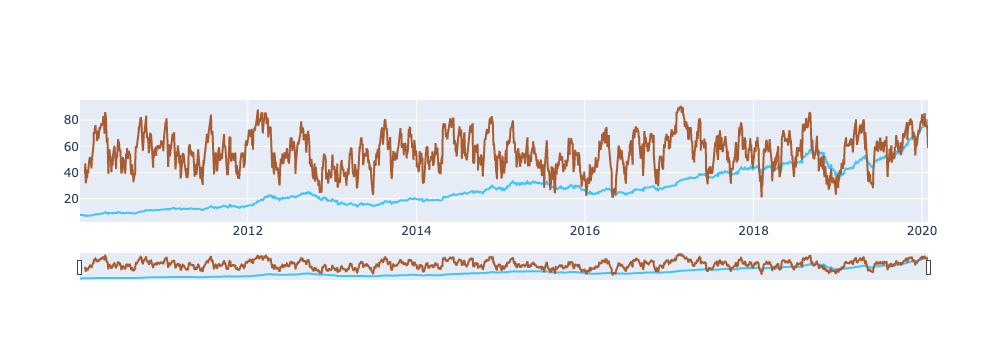

In [192]:
d

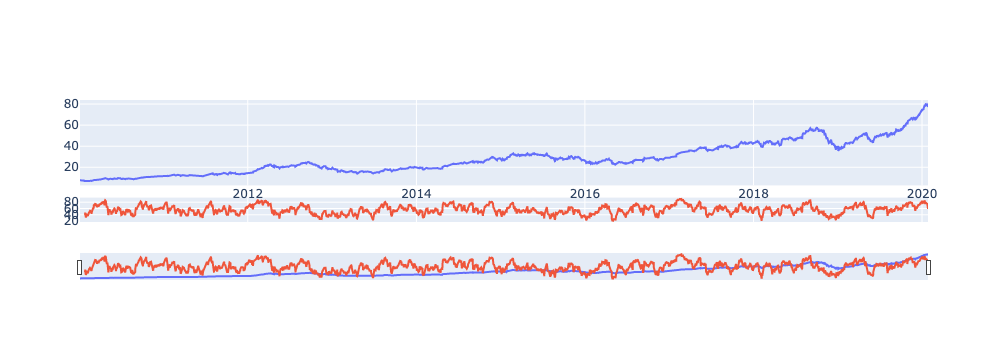

In [121]:




layoutt = go.Layout(autosize=True)
fig_001 = go.Figure(
     data=[
        go.Scatter(x=data.index.values,y=data["Close"].values,yaxis="y1", name=f"prueba plot"),
        go.Scatter(x=rsi_df.index, y=rsi_df["rsi"], yaxis="y2"),
    ],
    layout=layoutt,
).update_layout(
    yaxis_domain=[0.3, 1],
    yaxis2={"domain": [0, 0.20]},
    xaxis_rangeslider_visible=True,
    showlegend=False,
)

# fig = px.line(data, y="Close",yaxis="y1", title=f"prueba plot")
# fig.add_trace(
#     go.Scatter(x=rsi_df.index, y=rsi_df["rsi"], yaxis="y2",visible='legendonly')
# )
# fig.update_xaxes(rangeslider_visible=True)

fig_001

In [77]:
d = {}


KeyError: 'At least need stock data to update the graph, add it'